# HouseSalesPrediction

# DAY2

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import graphviz
import pydotplus

### データの取り込み

In [2]:
df_data=pd.read_csv("../1_data/housesalesprediction/kc_house_data.csv")
df_data["price"]=df_data["price"]/10**6 #単位を100万ドルにしておく
#print(df_data.columns)
#print(df_data.head())

## 1.目的変数間と説明変数間のグラフ作成

In [3]:
#相間行列の作成
df_data.corr().style.background_gradient().format('{:.2f}')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.00,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01,-0.01,-0.01,0.02,-0.02,-0.01,-0.00,0.02,-0.00,-0.14
price,-0.02,1.00,0.31,0.53,0.70,0.09,0.26,0.27,0.40,0.04,0.67,0.61,0.32,0.05,0.13,-0.05,0.31,0.02,0.59,0.08
bedrooms,0.00,0.31,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03
bathrooms,0.01,0.53,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09
sqft_living,-0.01,0.70,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72
floors,0.02,0.26,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01
waterfront,-0.00,0.27,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.09,0.03,-0.01,-0.04,0.09,0.03
view,0.01,0.40,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.10,0.08,0.01,-0.08,0.28,0.07
condition,-0.02,0.04,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.00,-0.01,-0.11,-0.09,-0.00


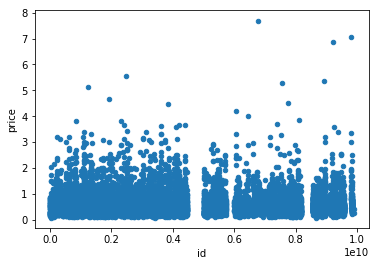

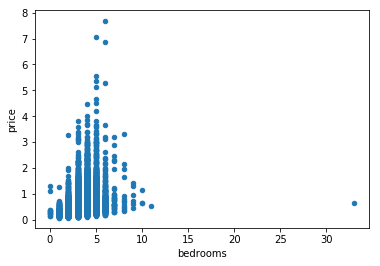

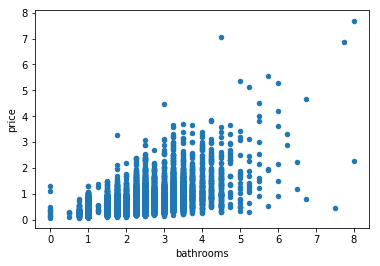

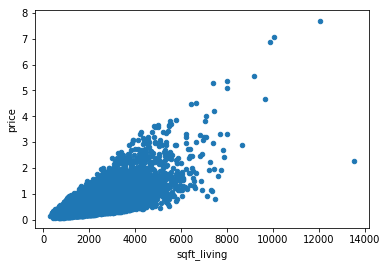

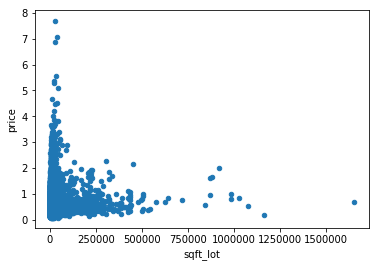

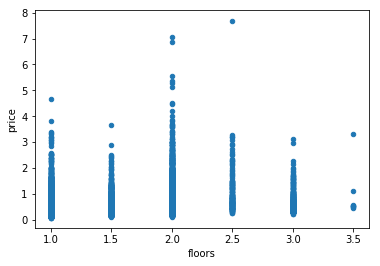

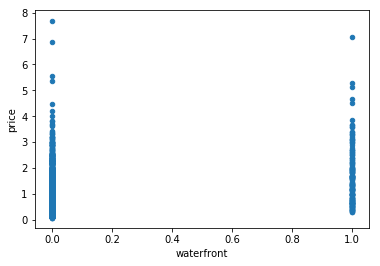

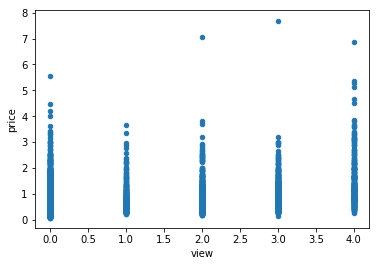

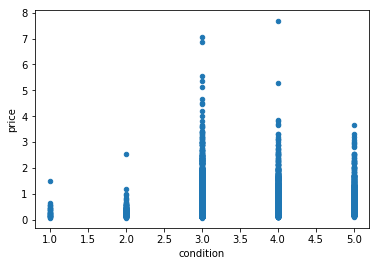

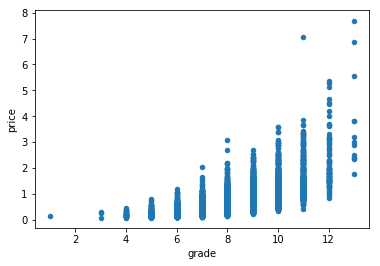

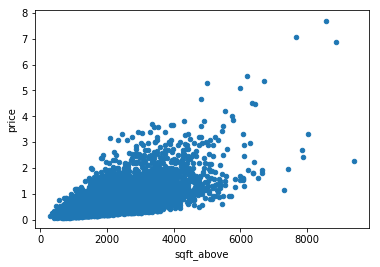

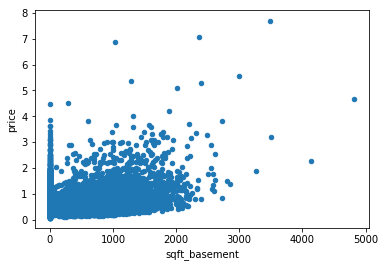

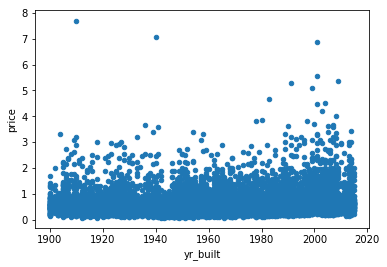

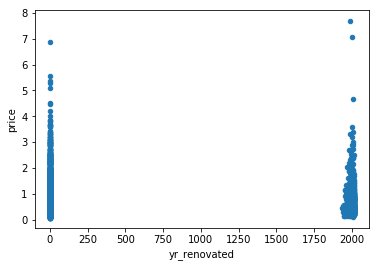

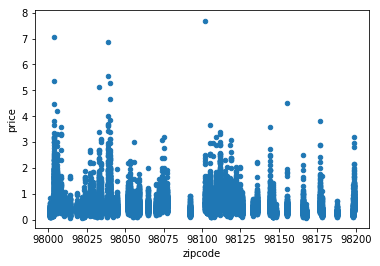

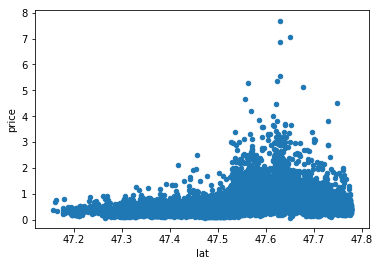

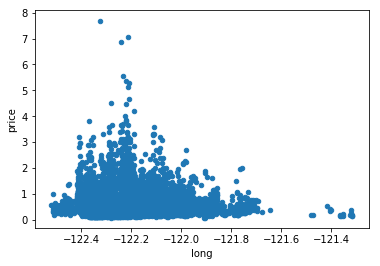

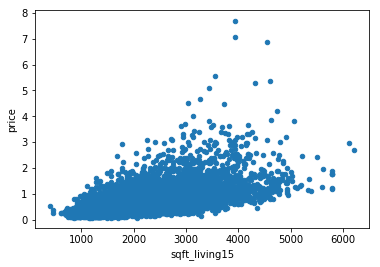

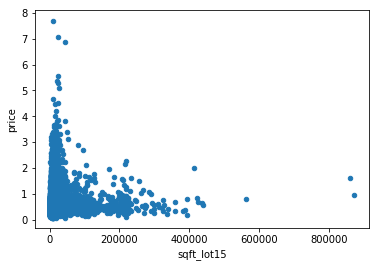

In [4]:
for col in df_data.columns:
    if (col != 'price') & ( col != 'date'):
        df_data[[col,'price']].plot(kind='scatter',x=col,y='price')

下記のデータは相間図が直線に近く、目的変数との関連が高そうに見える
- bathroom  
- sqft_living  
- grade  
- sqft_above  
- sqft_living15  

## 2.欠測値と異常値の処理

### 欠測値の処理

In [5]:
# そもそも欠測値があるのかどうか調べる
# coutn missing
pd.DataFrame(df_data.isnull().sum(), columns=["num of missing"])

,num of missing
id,0
date,0
price,0
bedrooms,0
bathrooms,0
sqft_living,0
sqft_lot,0
floors,0
waterfront,0
view,0


In [6]:
# 線形補間を実施(欠測値なしのため特に処理は走らないはず)
for col in df_data.columns:
    df_data[col]=df_data[col].interpolate()
# print(df_data.head())

## 3.特徴量エンジニアリング

In [7]:
# データタイプの確認
for col in df_data.columns:
    print("{0} : {1}".format(col,df_data[col].dtype))

id : int64
date : object
price : float64
bedrooms : int64
bathrooms : float64
sqft_living : int64
sqft_lot : int64
floors : float64
waterfront : int64
view : int64
condition : int64
grade : int64
sqft_above : int64
sqft_basement : int64
yr_built : int64
yr_renovated : int64
zipcode : int64
lat : float64
long : float64
sqft_living15 : int64
sqft_lot15 : int64


dateの型がobjectになっているため、日付に変換

In [8]:
df_data["date"]=pd.to_datetime(df_data.date)
print(df_data.date.head())

# datetimeオブジェクトはそのまま扱えないため、年月日それぞれに分ける
df_data["sold_year"] = df_data["date"].map(lambda x: x.year)
df_data["sold_month"] = df_data["date"].map(lambda x: x.month)
df_data["sold_date"] = df_data["date"].map(lambda x: x.day)
# print(df_data["sold_year"].head())
# print(df_data["sold_month"].head())
# print(df_data["sold_date"].head())


# 年月日のデータを抽出したので、代わりにdateはdropさせる
df_data_01 = df_data.drop("date",1)


0   2014-10-13
1   2014-12-09
2   2015-02-25
3   2014-12-09
4   2015-02-18
Name: date, dtype: datetime64[ns]


カテゴリカル変数のone-hotベクトルへの変換

In [9]:
# 今回のデータでは文字列で表されているデータがない

In [10]:
# リノベーション年はリノベーションしたかどうかに変換する
df_data_01['yr_renovated_bin'] = np.array(df_data_01['yr_renovated'] != 0)*1
df_data_01['yr_renovated_bin'].value_counts().sort_index()

0    20699
1      914
Name: yr_renovated_bin, dtype: int64

In [11]:
# リノベーションした年のデータは捨てる
df_data_02 = df_data_01.drop("yr_renovated",axis=1)

多重共線性の確認

In [29]:
from sklearn.linear_model import LinearRegression

df_data_vif = df_data_02.drop(["price"],axis=1)
for cname in df_data_vif.columns:  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
    rsquared = regr.score(X_vif,y_vif)
    print(cname,":" ,1/(1-np.power(rsquared,2)))

id : 1.0007586500315633
bedrooms : 1.1846612742020783
bathrooms : 1.9693068406021106
sqft_living : inf
sqft_lot : 1.3819814384288798
floors : 1.3390420288927114
waterfront : 1.0295725958746862
view : 1.1018662101812966
condition : 1.0428743312598692
grade : 2.002803729348247
sqft_above

C:\Users\y-izumi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


 : inf
sqft_basement : inf
yr_built : 1.530182547137691
zipcode : 1.1887897532794272
lat : 1.024211737620428
long : 1.2597548823357523
sqft_living15 : 1.790505975321611
sqft_lot15 : 1.3991500228358764
sold_year : 1.6162011576658715
sold_month : 1.615951210219606
sold_date : 1.0001548787947694
yr_renovated_bin : 1.017664342011129


多重共線性を確認したところ、10以上の値は見られないものの,「0で割っている」という趣旨のメッセージが出ている  
doubleの丸めによるものと思われるが、sqft_aboveとsqft_basementが$\large VIF_i = \infty$となっており、
多重共線性があると予想されるため、どの変数間に多重共線性があるか確認する

In [44]:
for cname in "sqft_above","sqft_basement":  
    y_vif=df_data_vif[cname]
    X_vif=df_data_vif.drop(cname, axis=1)
    regr = LinearRegression(fit_intercept=True)
    regr.fit(X_vif, y_vif)
    print(X_vif.columns)
    print(regr.coef_)
# どうも、dataframeの後ろに放り込むのは2次元配列じゃないとだめっぽい
    coef = pd.DataFrame(columns=X_vif.columns,data=regr.coef_)
#     print(cname,":" ,regr.coef_)

Index(['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'yr_built',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sold_year',
       'sold_month', 'sold_date', 'yr_renovated_bin'],
      dtype='object')
[-2.12921293e-18 -1.18221702e-14 -7.88221108e-13  1.00000000e+00
 -4.80755739e-17  3.88886415e-13  1.46163413e-12 -1.08370233e-13
 -4.26141128e-14  1.38403711e-14 -1.00000000e+00 -1.13495616e-15
  1.85422309e-15 -4.09386153e-14  3.62906216e-13 -4.92299914e-16
  9.44733618e-17  7.28157561e-15  1.03225759e-15 -3.12019825e-16
 -3.23566019e-15]


ValueError: Shape of passed values is (1, 21), indices imply (21, 21)

### モデルの適用

In [13]:
# 説明変数と目的変数に分ける

# 相関係数が0.3以上の変数を抽出し、説明変数として設定する
# 目的変数はprice
corr = pd.DataFrame(columns=df_data_02.columns,data= df_data_02.corr())
# print(corr.loc["price","bedrooms"])

print(df_data_02.columns)
X_columns=[]
for col in df_data_02.columns:
    if(corr.loc["price",col]>0.3):
        X_columns.append(col)
# print(X_columns)
X=df_data_02[X_columns]
X=X.drop("price",1)
Y=df_data_02["price"]
# print(X.head())
# print(Y.head())
# print(X.columns)

Index(['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'sold_year', 'sold_month', 'sold_date',
       'yr_renovated_bin'],
      dtype='object')


In [14]:
# 相関行列を確認し、実際に相関係数が0,3以上の目的変数が抽出されていることを確認
df_data_02.corr().style.background_gradient().format('{:.2f}')

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,sold_year,sold_month,sold_date,yr_renovated_bin
id,1.00,-0.02,0.00,0.01,-0.01,-0.13,0.02,-0.00,0.01,-0.02,0.01,-0.01,-0.01,0.02,-0.01,-0.00,0.02,-0.00,-0.14,0.01,-0.01,0.00,-0.02
price,-0.02,1.00,0.31,0.53,0.70,0.09,0.26,0.27,0.40,0.04,0.67,0.61,0.32,0.05,-0.05,0.31,0.02,0.59,0.08,0.00,-0.01,-0.01,0.13
bedrooms,0.00,0.31,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,-0.15,-0.01,0.13,0.39,0.03,-0.01,-0.00,-0.01,0.02
bathrooms,0.01,0.53,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,-0.20,0.02,0.22,0.57,0.09,-0.03,0.01,-0.01,0.05
sqft_living,-0.01,0.70,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,-0.20,0.05,0.24,0.76,0.18,-0.03,0.01,-0.01,0.06
sqft_lot,-0.13,0.09,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,-0.13,-0.09,0.23,0.14,0.72,0.01,-0.00,0.00,0.01
floors,0.02,0.26,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,-0.06,0.05,0.13,0.28,-0.01,-0.02,0.01,-0.01,0.01
waterfront,-0.00,0.27,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.03,-0.01,-0.04,0.09,0.03,-0.00,0.01,0.01,0.09
view,0.01,0.40,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.08,0.01,-0.08,0.28,0.07,0.00,-0.01,0.01,0.10
condition,-0.02,0.04,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,0.00,-0.01,-0.11,-0.09,-0.00,-0.05,0.02,-0.00,-0.06


説明変数の標準化

In [41]:
# 説明変数の標準化を行う

from sklearn.preprocessing import StandardScaler
stdsc=StandardScaler()
# print(stdsc.fit_transform(X))
X_std = pd.DataFrame(columns=X.columns,data=stdsc.fit_transform(X))
# X_std = stdsc.fit_transform(X)

print(X_std.head())

   bedrooms  bathrooms  sqft_living      view     grade  sqft_above  \
0 -0.398737  -1.447464    -0.979835 -0.305759 -0.558836   -0.734708   
1 -0.398737   0.175607     0.533634 -0.305759 -0.558836    0.460841   
2 -1.473959  -1.447464    -1.426254 -0.305759 -1.409587   -1.229834   
3  0.676485   1.149449    -0.130550 -0.305759 -0.558836   -0.891699   
4 -0.398737  -0.149007    -0.435422 -0.305759  0.291916   -0.130895   

   sqft_basement       lat  sqft_living15  
0      -0.658681 -0.352572      -0.943355  
1       0.245141  1.161568      -0.432686  
2      -0.658681  1.283537       1.070140  
3       1.397515 -0.283288      -0.914174  
4      -0.658681  0.409550      -0.272190  


In [16]:
# 2割をテストデータとして利用
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=3)


## scikit-learnで決定木を生成する

In [17]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz

reg = DecisionTreeRegressor(criterion="mse", max_depth=3, min_samples_split=3, min_samples_leaf=3, random_state=1234)
# min_sample_leaf 最低でも葉が3つ残る切り方
reg = reg.fit(X_train, Y_train)
# max_depth:木の深さ　どこかで決定木を打ち切る 過学習の防止
print("score=", reg.score(X_train, Y_train))
print(reg.predict(X_test)) #予測したい場合

score= 0.6093205861095816
[0.46323695 1.57107634 0.91985094 ... 0.91985094 1.57107634 0.27187625]


[0.         0.         0.32869081 0.         0.5180129  0.
 0.         0.15329629 0.        ]


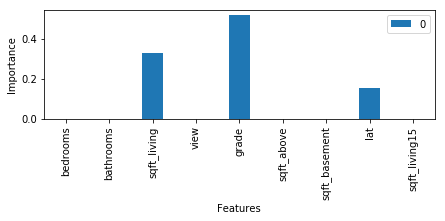

In [18]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(reg.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
pd.DataFrame(reg.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

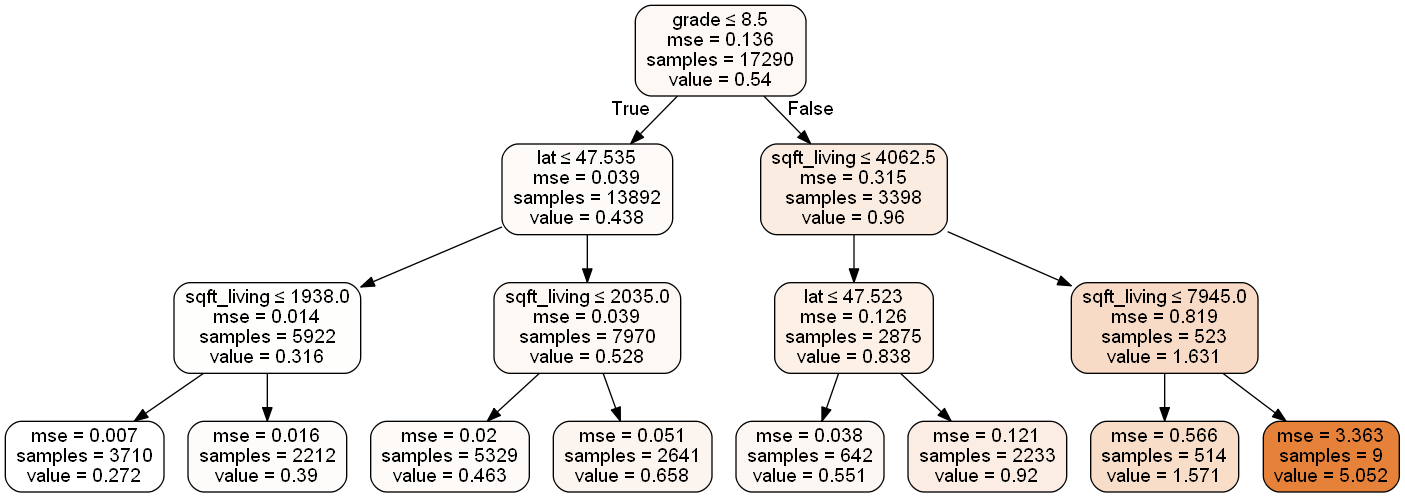

In [19]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(reg, out_file=dot_data,
                     feature_names=X.columns,  
#                      class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

精度の評価

In [20]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error


#MSE,RMSE,MAEの計算
Y_pred=reg.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
mae=mean_absolute_error(Y_test,Y_pred)

print("MSE=%s"%round(mse,3))
print("RMSE=%s"%round(np.sqrt(mse), 3) )
print("MAE=%s"%round(mae,3) )


MSE=0.053
RMSE=0.23
MAE=0.136


## 6.交差検証による確認

交差検証

In [21]:
# from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':list(range(1, 10))}
cv = GridSearchCV(reg,param_grid=param_grid,cv=5)
cv.fit(X_test,Y_test)

print(cv.best_score_)
print(cv.best_params_)
print(cv.best_estimator_)


0.6492730584924865
{'max_depth': 7}
DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')


In [22]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_error

# print(X_test)

# reg = DecisionTreeRegressor(criterion="mse", max_depth=7, min_samples_split=3, min_samples_leaf=3, random_state=1234)
reg = cv.best_estimator_
#min_sample_leaf 最低でも葉が3つ残る切り方
reg = reg.fit(X_train, Y_train)


#MSE,RMSE,MAEの計算
Y_pred=reg.predict(X_test)
mse=mean_squared_error(Y_test,Y_pred)
mae=mean_absolute_error(Y_test,Y_pred)

print("MSE=%s"%round(mse,3))
print("RMSE=%s"%round(np.sqrt(mse), 3) )
print("MAE=%s"%round(mae,3) )


MSE=0.037
RMSE=0.193
MAE=0.109


[0.00099103 0.00229201 0.31525534 0.05123516 0.4156698  0.00457229
 0.00307754 0.19956823 0.00733859]


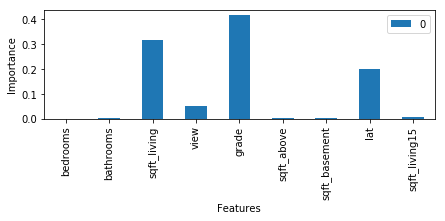

In [23]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(reg.feature_importances_)
# pd.DataFrame(reg.feature_importances_, index=).plot.bar(figsize=(7,2))
pd.DataFrame(reg.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

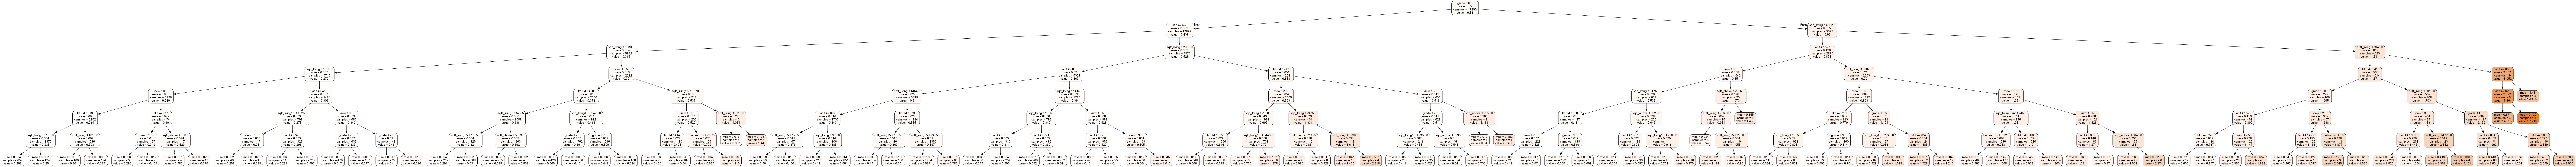

In [24]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO

# 決定木の描画
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(reg, out_file=dot_data,
                     feature_names=X.columns,  
#                      class_names=["0","1"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())